In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [41]:
train_dir = '/kaggle/input/cards-image-datasetclassification'
val_dir = '/kaggle/input/cards-image-datasetclassification'
test_dir ='/kaggle/input/cards-image-datasetclassification'

In [42]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [43]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

In [44]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
classes = train_loader.dataset.classes
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [45]:
def imshow(images, labels, class_names):
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.title(", ".join([class_names[l] for l in labels]))
    plt.show()

In [46]:
# Отримуємо список класів (назви категорій зображень)
class_names = train_loader.dataset.classes

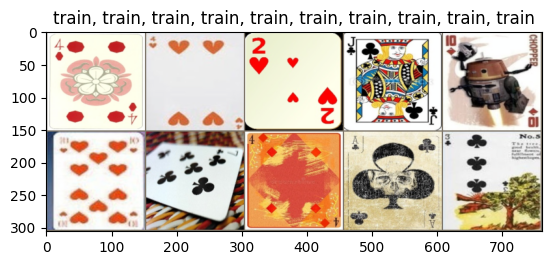

In [47]:
# Виводимо 10 зображень із тренувального набору
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Відображаємо зображення
imshow(make_grid(images[:10], nrow=5), labels[:10], class_names)

In [48]:
print(f"Кількість класів: {len(train_dataset.classes)}")
print(f"Класи: {train_dataset.classes}")
print(f"Розмір тренувального набору: {len(train_dataset)}")
print(f"Розмір валідаційного набору: {len(val_dataset)}")
print(f"Розмір тестового набору: {len(test_dataset)}")

# Перевірка балансу класів у тренувальному наборі
class_counts = {class_name: 0 for class_name in train_dataset.classes}
for _, label in train_dataset.samples:
    class_counts[train_dataset.classes[label]] += 1

print("\nРозподіл класів у тренувальному наборі:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Кількість класів: 3
Класи: ['test', 'train', 'valid']
Розмір тренувального набору: 8154
Розмір валідаційного набору: 8154
Розмір тестового набору: 8154

Розподіл класів у тренувальному наборі:
test: 265
train: 7624
valid: 265


In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=36):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Обчислити розмір вхідних даних для повнозв'язного шару
        self._initialize_fc_layer()
        
        self.fc1 = nn.Linear(self.fc1_in_features, 512)
        self.fc2 = nn.Linear(512, num_classes)
    def _initialize_fc_layer(self):
        # Прокинемо зображення через конволюційні шари, щоб дізнатися розмір
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)
            dummy_output = self._forward_conv_layers(dummy_input)
            self.fc1_in_features = dummy_output.numel()

    def _forward_conv_layers(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self._forward_conv_layers(x)
        x = x.view(-1, self.fc1_in_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [50]:
model = SimpleCNN(num_classes=36)

# Перенесення моделі на GPU, якщо доступно
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Налаштування тренувального процесу
num_epochs = 7
best_val_loss = float('inf')
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [52]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_1.pth')

100%|██████████| 255/255 [00:27<00:00,  9.15it/s]


Epoch 1/7:
Train Loss: 2.1821, Train Accuracy: 0.8920
Val Loss: 0.5603, Val Accuracy: 0.9349


100%|██████████| 255/255 [00:28<00:00,  8.81it/s]


Epoch 2/7:
Train Loss: 0.3759, Train Accuracy: 0.9248
Val Loss: 0.2407, Val Accuracy: 0.9354


100%|██████████| 255/255 [00:28<00:00,  8.97it/s]


Epoch 3/7:
Train Loss: 0.3024, Train Accuracy: 0.9311
Val Loss: 0.3415, Val Accuracy: 0.9003


100%|██████████| 255/255 [00:28<00:00,  9.02it/s]


Epoch 4/7:
Train Loss: 0.2671, Train Accuracy: 0.9335
Val Loss: 0.3359, Val Accuracy: 0.9350


100%|██████████| 255/255 [00:28<00:00,  9.05it/s]


Epoch 5/7:
Train Loss: 0.2533, Train Accuracy: 0.9340
Val Loss: 0.2543, Val Accuracy: 0.9373


100%|██████████| 255/255 [00:28<00:00,  9.08it/s]


Epoch 6/7:
Train Loss: 0.2375, Train Accuracy: 0.9345
Val Loss: 0.2242, Val Accuracy: 0.9350


100%|██████████| 255/255 [00:28<00:00,  9.08it/s]


Epoch 7/7:
Train Loss: 0.2279, Train Accuracy: 0.9355
Val Loss: 0.1970, Val Accuracy: 0.9371


In [53]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images//2 + 1, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')

                # Денормалізація зображення для відображення
                inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                )
                inp = inv_normalize(inputs.cpu()[j]).numpy().transpose((1, 2, 0))
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

In [54]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [55]:
def evaluate_model(model, dataloader, class_names):
    model.eval()

    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Обчислення точності та F1 
    test_accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Створення матриці помилок
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return test_accuracy, all_preds, all_labels


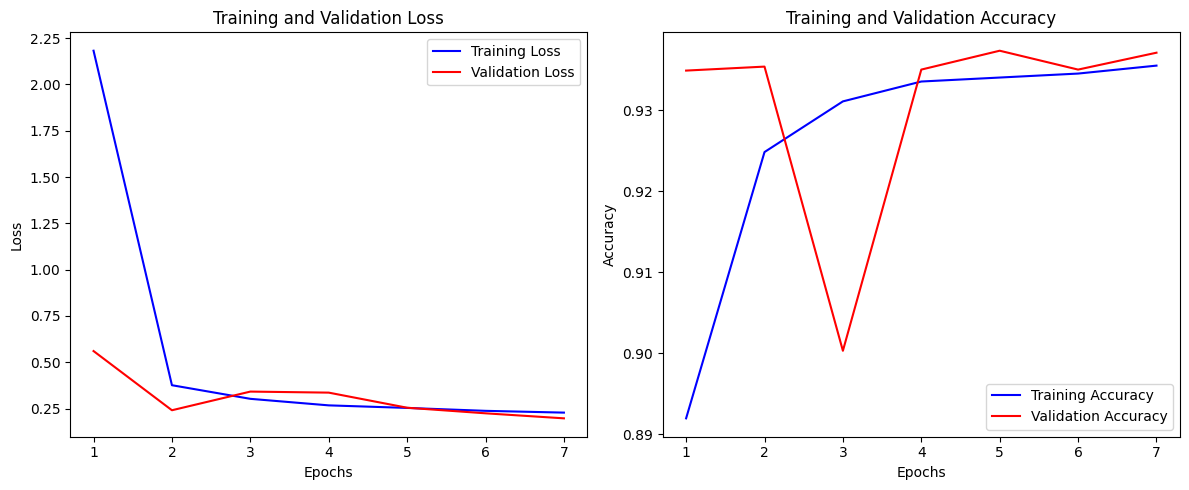

In [56]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

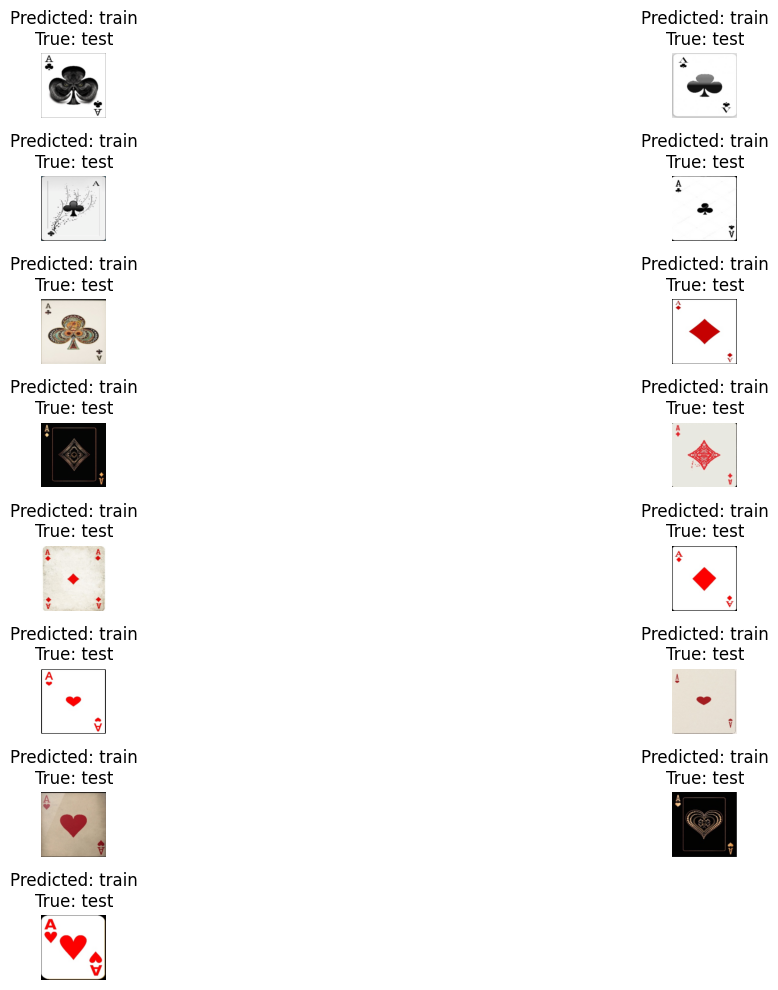

In [57]:
visualize_predictions(model, test_loader, train_dataset.classes, 15)


In [58]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, model_name='best_model.pth'):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        # Збереження найкращої моделі
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), model_name)

    return train_losses, val_losses, train_accuracies, val_accuracies


In [59]:
from torchvision import models
# Завантаження претренованої моделі VGG16
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False

num_classes = 36 
vgg16.classifier[6] = nn.Linear(4096, num_classes)

vgg16 = vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

train_losses_vgg, val_losses_vgg, train_accuracies_vgg, val_accuracies_vgg = train_model(
    vgg16, train_loader, val_loader, criterion, optimizer_vgg, num_epochs=3, model_name='best_model_vgg16.pth'
)


Epoch 1/3, Train Loss: 0.3550, Val Loss: 0.2354, Train Acc: 0.9264, Val Acc: 0.9372
Epoch 2/3, Train Loss: 0.2898, Val Loss: 0.2153, Train Acc: 0.9286, Val Acc: 0.9400
Epoch 3/3, Train Loss: 0.2826, Val Loss: 0.2209, Train Acc: 0.9297, Val Acc: 0.9404


Test Accuracy: 0.9404
F1 Score: 0.9166


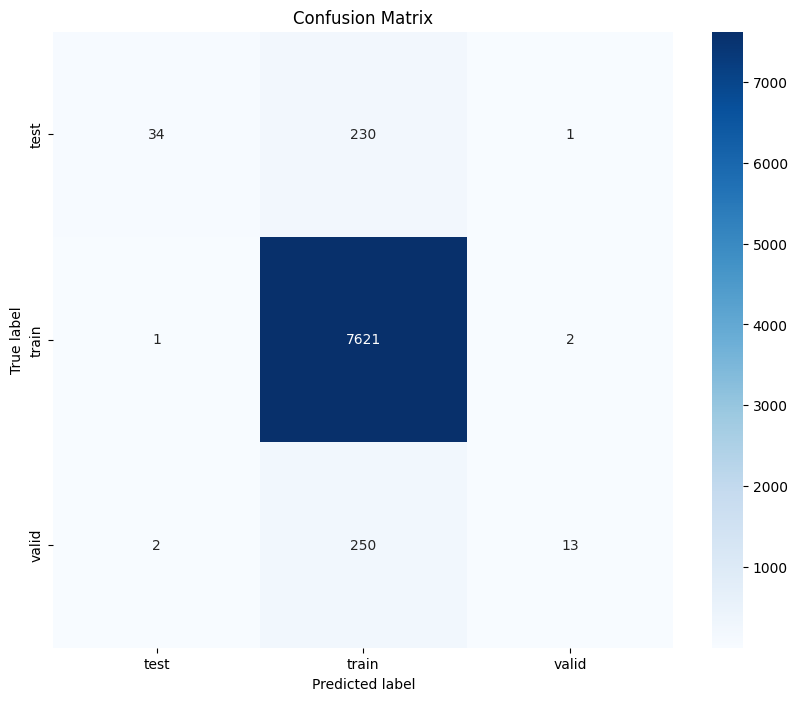

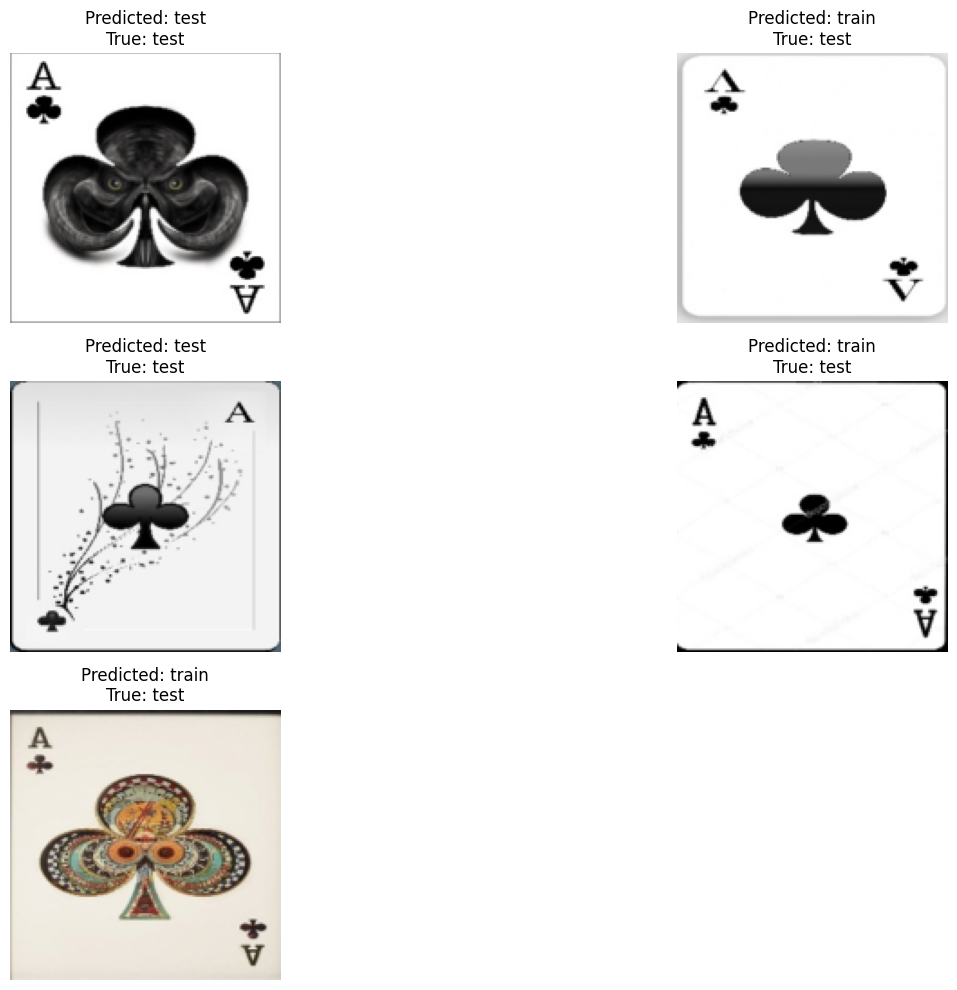

In [60]:
# Завантаження найкращої моделі
vgg16.load_state_dict(torch.load('best_model_vgg16.pth'))
test_accuracy_vgg, test_preds_vgg, test_labels_vgg = evaluate_model(vgg16, test_loader, classes)
# Візуалізація 
visualize_predictions(vgg16, test_loader, classes)



**Висновок:** 
У ході виконання цієї лабораторної роботи було реалізовано дві моделі для класифікації зображень за допомогою PyTorch: згорткову нейронну мережу CNN та претреновану модель VGG16. Обидві моделі були навчені на датасеті Cards Image Dataset-Classification, після чого проведено оцінювання їхньої точності на тестових даних. Також було побудовано матриці плутанини та криві навчання, які відображають зміну точності та функції втрат у процесі тренування. Далі було реалізовано візуалізацію прикладів передбачень моделі.